In [1]:
import os
import torch
from zipfile import ZipFile
import urllib.request
import json
import collections

root_dir = "datasets"
annotations_dir = os.path.join(root_dir, "annotations")
images_dir = os.path.join(root_dir, "train2017")
annotation_file = os.path.join(annotations_dir, "captions_train2017.json")

# Download caption annotation files
if not os.path.exists(annotations_dir):
    annotation_zip_url = "http://images.cocodataset.org/annotations/annotations_trainval2017.zip"
    annotation_zip_path = os.path.join(os.path.abspath("."), "captions.zip")
    urllib.request.urlretrieve(annotation_zip_url, annotation_zip_path)
    with ZipFile(annotation_zip_path, 'r') as zip_ref:
        zip_ref.extractall(annotations_dir)
    os.remove(annotation_zip_path)

# Download image files
if not os.path.exists(images_dir):
    image_zip_url = "http://images.cocodataset.org/zips/train2017.zip"
    image_zip_path = os.path.join(os.path.abspath("."), "train2017.zip")
    urllib.request.urlretrieve(image_zip_url, image_zip_path)
    with ZipFile(image_zip_path, 'r') as zip_ref:
        zip_ref.extractall(images_dir)
    os.remove(image_zip_path)

print("Dataset is downloaded and extracted successfully.")


Dataset is downloaded and extracted successfully.


In [2]:
import os
import json
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class CLIPDataset(Dataset):
    def __init__(self, root_dir, annotation_file, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        # self.image_path_to_caption = self.load_annotations(annotation_file)
        # self.image_paths = list(self.image_path_to_caption.keys())
        self.caption_list, self.image_path_list = self.load_annotations(annotation_file)

    def load_annotations(self, annotation_file):
        with open(annotation_file, "r") as f:
            annotations = json.load(f)["annotations"]

        image_path_to_caption = collections.defaultdict(list)
        for element in annotations:
            caption = f"{element['caption'].lower().rstrip('.')}"
            image_path = os.path.join(self.root_dir, "train2017","train2017", "%012d.jpg" % (element["image_id"]))
            image_path_to_caption[image_path].append(caption)
        image_paths = list(image_path_to_caption.keys())
        caption_list, image_path_list = self.training_list(image_paths, image_path_to_caption)


        return caption_list, image_path_list


    def training_list(self, image_paths, image_path_to_caption):
      captions_per_image = 2
      caption_list = []
      image_path_list = []
      for image_path in image_paths:
          captions = image_path_to_caption[image_path][:captions_per_image]
          caption_list.extend(captions)
          image_path_list.extend([image_path] * len(captions))

      return caption_list, image_path_list



    def __len__(self):
        return len(self.caption_list)

    def __getitem__(self, idx):
        image_path = self.image_path_list[idx]
        caption = self.caption_list[idx]

        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return {"image": image, "caption": caption}

In [3]:
EMBED_DIM = 512
TRANSFORMER_EMBED_DIM = 768
MAX_LEN = 32 # Maximum length of text
TEXT_MODEL = "distilbert-base-multilingual-cased"

EPOCHS = 5
BATCH_SIZE = 128

In [4]:
# Define the transformation for the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
annotation_file = os.path.join(annotations_dir, "annotations", "captions_train2017.json")
# Create the CLIP dataset
clip_dataset = CLIPDataset(root_dir="datasets", annotation_file=annotation_file, transform=transform)

# Create the DataLoader
clip_dataloader = DataLoader(clip_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


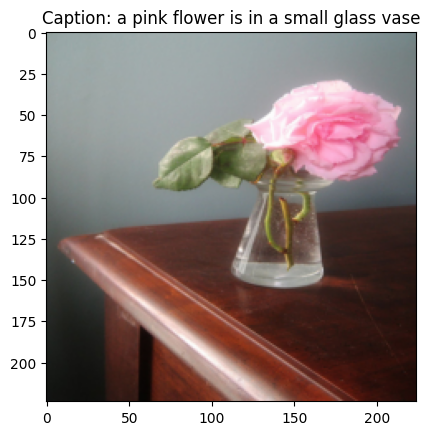

In [5]:
import numpy as np
import matplotlib.pyplot as plt
# Create an iterator from the dataloader
data_iter = iter(clip_dataloader)

# Get one batch
batch = next(data_iter)

# Extract the image and caption from the batch
image = batch["image"][0]  # Assuming batch size is greater than 0
caption = batch["caption"][0]

# Convert the image tensor to a NumPy array and permute dimensions
image_np = np.transpose(image.numpy(), (1, 2, 0))

# Display the image and caption
plt.imshow(image_np)
plt.title(f"Caption: {caption}")
plt.show()

In [6]:
batch["image"].shape

torch.Size([128, 3, 224, 224])

In [7]:
len(batch["caption"])

128

In [8]:
!pip install git+https://github.com/openai/CLIP.git --quiet

  Preparing metadata (setup.py) ... done


In [9]:
import torch.nn.functional as F

def CLIP_loss(logits: torch.Tensor) -> torch.Tensor:
    # Assuming n is the number of classes
    n = logits.shape[1]

    # Create labels tensor
    labels = torch.arange(n)

    # Calculate cross entropy losses along axis 0 and 1
    loss_i = F.cross_entropy(logits.transpose(0, 1), labels, reduction="mean")
    loss_t = F.cross_entropy(logits, labels, reduction="mean")

    # Calculate the final loss
    loss = (loss_i + loss_t) / 2

    return loss

def metrics(similarity: torch.Tensor):
    y = torch.arange(len(similarity)).to(similarity.device)
    img2cap_match_idx = similarity.argmax(dim=1)
    cap2img_match_idx = similarity.argmax(dim=0)

    img_acc = (img2cap_match_idx == y).float().mean()
    cap_acc = (cap2img_match_idx == y).float().mean()

    return img_acc, cap_acc

In [10]:
import clip
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

image = batch["image"].to(device)
true_text = batch["caption"]
wrong_text = true_text[::-1]


for captions in [true_text, wrong_text]:
    text = clip.tokenize(captions).to(device)

    # with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)

    # normalized features
    image_features = image_features / image_features.norm(dim=1, keepdim=True)
    text_features = text_features / text_features.norm(dim=1, keepdim=True)
    similarity = text_features @ image_features.T
    loss = CLIP_loss(similarity)
    print(loss)

tensor(4.7148, device='cuda:0', dtype=torch.float16, grad_fn=<DivBackward0>)
tensor(4.8516, device='cuda:0', dtype=torch.float16, grad_fn=<DivBackward0>)


In [11]:
from transformers import AutoModel, AutoTokenizer, BertTokenizer
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class Projection(nn.Module):
    def __init__(self, d_in: int, d_out: int, p: float=0.5) -> None:
        super().__init__()
        self.linear1 = nn.Linear(d_in, d_out, bias=False)
        self.linear2 = nn.Linear(d_out, d_out, bias=False)
        self.layer_norm = nn.LayerNorm(d_out)
        self.drop = nn.Dropout(p)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        embed1 = self.linear1(x)
        embed2 = self.drop(self.linear2(F.gelu(embed1)))
        embeds = self.layer_norm(embed1 + embed2)
        return embeds

class VisionEncoder(nn.Module):
    def __init__(self, d_out: int) -> None:
        super().__init__()
        base = models.resnet34(pretrained=True)
        d_in = base.fc.in_features
        base.fc = nn.Identity()
        self.base = base
        self.projection = Projection(d_in, d_out)
        for p in self.base.parameters():
            p.requires_grad = False

    def forward(self, x):
        projected_vec = self.projection(self.base(x))
        projection_len = torch.norm(projected_vec, dim=-1, keepdim=True)
        return projected_vec / projection_len

class TextEncoder(nn.Module):
    def __init__(self, d_out: int) -> None:
        super().__init__()
        self.base = AutoModel.from_pretrained(TEXT_MODEL)
        self.projection = Projection(TRANSFORMER_EMBED_DIM, d_out)
        for p in self.base.parameters():
            p.requires_grad = False

    def forward(self, x):
        out = self.base(x)[0]
        out = out[:, 0, :]  # get CLS token output
        projected_vec = self.projection(out)
        projection_len = torch.norm(projected_vec, dim=-1, keepdim=True)
        return projected_vec / projection_len

In [12]:
class Tokenizer:
    def __init__(self, tokenizer: BertTokenizer) -> None:
        self.tokenizer = tokenizer

    def __call__(self, x: str) -> AutoTokenizer:
        return self.tokenizer(
            x, max_length=MAX_LEN, truncation=True, padding=True, return_tensors="pt"
        )


In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
image = batch["image"].to(device)
true_text = batch["caption"]
wrong_text = true_text[::-1]

vision_encoder = VisionEncoder(EMBED_DIM).to(device)
caption_encoder = TextEncoder(EMBED_DIM).to(device)
tokenizer = Tokenizer(AutoTokenizer.from_pretrained(TEXT_MODEL))

for captions in [true_text, wrong_text]:
    text = tokenizer(captions).to(device)

    # with torch.no_grad():
    image_features = vision_encoder(image)
    text_features = caption_encoder(text["input_ids"])

    # normalized features
    image_features = image_features / image_features.norm(dim=1, keepdim=True)
    text_features = text_features / text_features.norm(dim=1, keepdim=True)
    similarity = text_features @ image_features.T
    loss = CLIP_loss(similarity)
    print(loss)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


tensor(4.8517, device='cuda:0', grad_fn=<DivBackward0>)
tensor(4.8511, device='cuda:0', grad_fn=<DivBackward0>)


In [14]:
import torch
import torch.nn as nn
from transformers import AutoTokenizer
from typing import List, Tuple


class CustomModel(nn.Module):
    def __init__(self, lr: float = 1e-3) -> None:
        super().__init__()
        self.vision_encoder = VisionEncoder(Config.embed_dim)
        self.caption_encoder = TextEncoder(Config.embed_dim)
        self.tokenizer = Tokenizer(AutoTokenizer.from_pretrained(Config.text_model))
        self.lr = lr
        self.device = "cuda" if torch.cuda.is_available() else "cpu"

    def forward(self, images, text):
        text = self.tokenizer(text).to(self.device)

        image_embed = self.vision_encoder(images)
        caption_embed = self.caption_encoder(text["input_ids"])
        similarity = caption_embed @ image_embed.T

        loss = CLIP_loss(similarity)
        img_acc, cap_acc = metrics(similarity)
        return loss, img_acc, cap_acc



In [15]:
# Create an instance of your model
model = CustomModel().to(device)

In [16]:
# Define optimizer
optimizer = torch.optim.Adam([
    {'params': model.vision_encoder.parameters()},
    {'params': model.caption_encoder.parameters()}
], lr=model.lr)


In [17]:

start_epoch = 0
num_epochs = 3

batch_zero = True
for epoch in range(start_epoch, num_epochs):
    model.train()
    for batch in clip_dataloader:
        image = batch["image"].to(device)
        text = batch["caption"]
        # images, text = batch
        loss, img_acc, cap_acc = model(image, text)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_zero:
          print(f"Epoch [{0}/{num_epochs}], Batch Loss: {loss.item()}")
          batch_zero = False


    # Print training statistics
    print(f"Epoch [{epoch+1}/{num_epochs}], Batch Loss: {loss.item()}")

print("Training complete.")

Epoch [0/5], Batch Loss: 4.854744911193848
Epoch [1/5], Batch Loss: 2.7482573986053467
Epoch [2/5], Batch Loss: 2.7431421279907227
Epoch [3/5], Batch Loss: 2.746194362640381
Epoch [4/5], Batch Loss: 2.7134761810302734
Epoch [5/5], Batch Loss: 2.813673257827759
Training complete.
